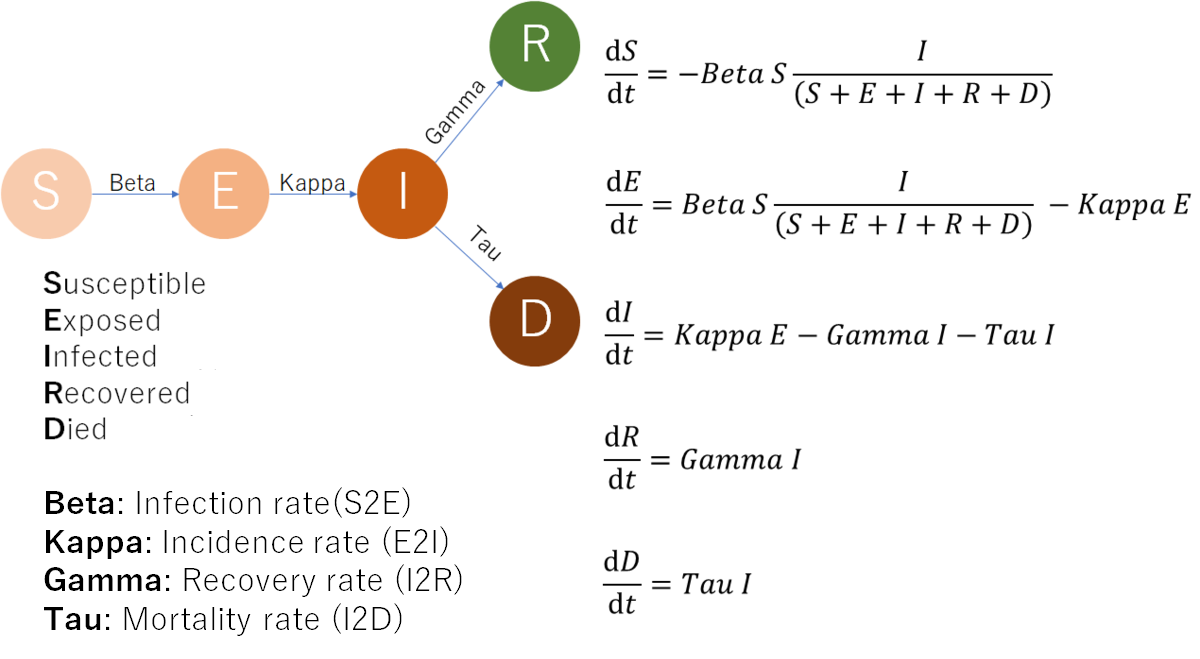

![](http://)

In [ ]:
# -*- coding: utf-8 -*-
import sys
import csv
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random
from datetime import datetime as dt
import datetime 
from decimal import Decimal, ROUND_HALF_UP
import re

class EstimationInfectedPeople():
    def __init__(self, name, population, data, latent_period = 5.8, mortality_rate = 0.02):

        self.name = name
        self.population = population

        self.timestamp = []
        self.infected = []
        self.deaths = []
        self.recovered = []
        self.confirmed = []
        self.values = []
        #self.deaths_confirmed = []
        #self.recovered_confirmed = []
        #self.delta_deaths = []
        #self.delta_recovered = []

        self.delta_deaths_divided_by_infected = []
        self.delta_recovered_divided_by_infected = []

        pre_deaths = 0
        pre_recovered = 0
        pre_infected = 0
        for date, values in data.items():
            #print(date)
            self.timestamp.append(dt.strptime(date, '%m/%d/%Y'))
            confirmed = int(values[0])
            deaths = int(values[1])
            recovered = int(values[2])
            infected = confirmed - deaths - recovered

            self.confirmed.append(confirmed)
            self.infected.append(infected)
            self.deaths.append(deaths)
            self.recovered.append(recovered)

            #self.deaths_confirmed.append(deaths/confirmed)
            #self.recovered_confirmed.append(recovered/confirmed)

            #self.delta_deaths.append(deaths - pre_deaths)
            #self.delta_recovered.append(recovered - pre_recovered)


            if pre_infected != 0:
                self.delta_deaths_divided_by_infected.append((deaths - pre_deaths)/pre_infected)
                self.delta_recovered_divided_by_infected.append((recovered - pre_recovered)/pre_infected)
            else:
                self.delta_deaths_divided_by_infected.append(0)
                self.delta_recovered_divided_by_infected.append(0)



            pre_deaths = deaths
            pre_recovered = recovered
            pre_infected = infected

        self.max = len(self.timestamp)
        self.dt = 0.01
        self.time = np.arange(0, self.max, self.dt)
        self.latent_period = latent_period
   
        self.mortality_rate = sum(self.delta_deaths_divided_by_infected)/len(self.delta_deaths_divided_by_infected)
        self.recovery_rate = sum(self.delta_recovered_divided_by_infected)/len(self.delta_recovered_divided_by_infected)


        print('self.mortality_rate',self.mortality_rate)
        print('self.recovery_rate',self.recovery_rate)

    def SEIR(self, vec, time, Beta):
        # vec[0]: S:Susceptible
        # vec[1]: E:Exposed
        # vec[2]: I:Infected  
        # vec[3]: R:Recovered  
        # vec[4]: D:Died     
        # 
        # Beta:Transfer coefficient
        # Kappa:Transition rate（E to I）
        # Gamma:recovery rate
        # Tau:mortality rate
        S = vec[0]
        E = vec[1]
        I = vec[2]
        R = vec[3]
        D = vec[4]
        N = S+E+I+R+D
        Kappa = 1/self.latent_period
        Gamma = self.recovery_rate
        Tau = self.mortality_rate
        return [-Beta*S*I/N, Beta*S*I/N-Kappa*E, Kappa*E - Gamma*I - Tau*I, Gamma*I, Tau*I]

    def estimate(self, Beta):
        vec=odeint(self.SEIR,self.initParams,self.time,args=(Beta,))
        est=vec[0:int(self.max/self.dt):int(1/self.dt)]
        return est

    def estimate4plot(self, Beta):
        multiple = 6
        v=odeint(self.SEIR,self.bestInitParams,np.arange(0, self.max * multiple, self.dt),args=(Beta,))
        est=v[0:int(self.max * multiple/self.dt):int(1/self.dt)]
        return est

    def func(self, params):
        est_i=self.estimate(params[0])
        return np.sum(est_i[:,2] - self.infected * np.log(est_i[:,2]))

    def getRandLP(self):
        a = random.normalvariate(self.lp, 5)
        if a < 0:
            a *= -1
        return self.lp

    def getEstimatedParams(self):
        no_new_record_cnt = 0
        max_fun = 0
        bounds = [(0, None)]
        initParams = [0.001]
        step = int(self.confirmed[len(self.confirmed)-1]/10)
        for susceptible in range(self.confirmed[len(self.confirmed)-1], self.population,step ):
            self.initParams = [susceptible, 0, np.min(self.confirmed), 0, 0]
            estimatedParams = minimize(self.func,initParams,method="L-BFGS-B", bounds=bounds)
            if estimatedParams.success == True:
                if max_fun < -estimatedParams.fun:
                    no_new_record_cnt = 0
                    max_fun = -estimatedParams.fun
                    best_population = population
                    self.bestEstimatedParams = estimatedParams
                    self.bestInitParams = self.initParams
                else:
                    no_new_record_cnt += 1
                    if no_new_record_cnt > 250:
                        print('Susceptible:',susceptible, ' Score:',max_fun)
                        break

        return self.bestEstimatedParams

    def plot(self, ax, estimatedParams):
        self.plot_bar(ax)
        self.plot_estimation(ax, estimatedParams)

        ax.set_xlabel('Date',fontsize=20)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
        ax.set_title(self.name,fontsize=25)
        ax.grid()

    def plot_bar(self, ax):
        width = 0.5
        for day, infected, recovered, deaths in zip(self.timestamp, self.infected, self.recovered, self.deaths ):
            bottom = 0
            ax.bar(day, infected, width, bottom, color='red', label='Infectious')
            bottom += infected
            ax.bar(day, recovered, width, bottom, color='blue', label='Recovered')
            bottom += recovered
            ax.bar(day, deaths, width, bottom, color='black', label='Deaths')
            bottom += deaths

        ax.set_ylabel('Confirmed infections',fontsize=20)
        handler, label = ax.get_legend_handles_labels()
        ax.legend(handler[0:3] , label[0:3], loc="upper left", borderaxespad=0. , fontsize=20)

        return 

    def plot_estimation(self, ax, estimatedParams):
        day = self.timestamp[0]
        day_list = []
        max = 0
        estimated_value_list = []
        for estimated_value in self.estimate4plot(estimatedParams.x[0])[:,2]:
            if max < estimated_value:
                max = estimated_value
                peak = (day, estimated_value)

            day_list.append(day)
            estimated_value_list.append(estimated_value)
            day += datetime.timedelta(days=1) 
            if estimated_value < 0:
                break
        ax.annotate(peak[0].strftime('%Y/%m/%d') + ' ' + str(int(peak[1])), xy = peak, size = 20, color = "black")
        ax.plot(day_list, estimated_value_list, color='red', label="Estimation infection", linewidth=3.0)

        day = self.timestamp[0]
        day_list = []
        estimated_value_list = []
        for estimated_value in self.estimate4plot(estimatedParams.x[0])[:,3]:
            day_list.append(day)
            estimated_value_list.append(estimated_value)
            day += datetime.timedelta(days=1) 
            if estimated_value < 0:
                break
        ax.plot(day_list, estimated_value_list, color='blue', label="Estimation recovered", linewidth=3.0)

        day = self.timestamp[0]
        day_list = []
        estimated_value_list = []
        for estimated_value in self.estimate4plot(estimatedParams.x[0])[:,4]:
            day_list.append(day)
            estimated_value_list.append(estimated_value)
            day += datetime.timedelta(days=1) 
            if estimated_value < 0:
                break
        ax.plot(day_list, estimated_value_list, color='black', label="Estimation deaths", linewidth=3.0)

        ax.set_ylim(0,) 

        handler, label = ax.get_legend_handles_labels()
        ax.legend(handler[0:6] , label[0:6], loc="upper right", borderaxespad=0. , fontsize=20)

        return 

    def print_estimation(self, estimatedParams):
        print('<<' + self.name + '>>')
        print('Beta:', Decimal(estimatedParams.x[0]).quantize(Decimal('.000000'),rounding=ROUND_HALF_UP))
        print('Kappa:', Decimal(1/self.latent_period).quantize(Decimal('.000000'),rounding=ROUND_HALF_UP))
        print('Gamma:', Decimal(self.recovery_rate).quantize(Decimal('.000000'),rounding=ROUND_HALF_UP))
        print('Tau:', Decimal(self.mortality_rate).quantize(Decimal('.000000'),rounding=ROUND_HALF_UP))


    def save_plot(self,title=''):
        output = 'new_coronavirus_' + self.name + '_' + title + '.png'
        plt.savefig(output) 

def convert_count_by_country(csv_data):
    data = {}
    for date, country, confirmed ,deaths, recovered in zip(csv_data['ObservationDate'], csv_data['Country/Region'],csv_data['Confirmed'],csv_data['Deaths'],csv_data['Recovered']):
        #print('1:',date)
        if len(date) == 8:
            #date = re.sub("[0-9]{2}:[0-9]{2}:[0-9]{2}","",date)
            #print('1-1:', re.sub(r'(^[0-9]{2}/[0-9]{2}/)[0-9]{2}$',r'\1',date))
            #print('1-2:', re.sub(r'^[0-9]{2}/[0-9]{2}/([0-9]{2}$)',r'20\1',date))
            date = re.sub(r'(^[0-9]{2}/[0-9]{2}/)[0-9]{2}$',r'\1',date) + re.sub(r'^[0-9]{2}/[0-9]{2}/([0-9]{2}$)',r'20\1',date)
        #print('2:',date)

        if country not in data:
            data.setdefault(country,{date:[0, 0, 0]})

        if date not in data[country]:
            data[country].setdefault(date, [0, 0, 0])

        data[country][date][0] += float(confirmed)
        data[country][date][1] += float(deaths)
        data[country][date][2] += float(recovered)

    return data

def read_csv(filename):
    data = {}
    with open(filename) as f:
        reader = csv.reader(f)
        header = next(reader)
        for row in reader:
            for cnt, name in enumerate(header):
                if name not in data:
                    data[name] = []
                data[name].append(row[cnt])
    return convert_count_by_country(data)

if __name__ == '__main__':

    ############################################################
    # Read csv file 
    ############################################################
    args = sys.argv
    filename = "../input/novel-corona-virus-2019-dataset/covid_19_data.csv"
    data = read_csv(filename)
    
    
    ############################################################
    # Estimation infections in Italy
    ############################################################
    population = 60000000
    fig = plt.figure(figsize=(20,10),dpi=200)
    ax = fig.add_subplot(1, 1, 1)
    fig.suptitle('Infections of a new coronavirus in Italy', fontsize=30)
    Italy = EstimationInfectedPeople('Italy', population, data['Italy'])
    Italy.plot_bar(ax)
    Italy.save_plot('obcerved') 

    estParams = Italy.getEstimatedParams()
    print(estParams)
    Italy.print_estimation(estParams)
    Italy.plot(ax, estParams)
    Italy.save_plot('estimation') 
    ax.clear()
    
    
    ############################################################
    # Estimation infections in India
    ############################################################
    population = 52000000
    fig = plt.figure(figsize=(20,10),dpi=200)
    ax = fig.add_subplot(1, 1, 1)
    fig.suptitle('Infections of a new coronavirus in India', fontsize=30)
    India = EstimationInfectedPeople('India', population, data['India'])
    India.plot_bar(ax)
    India.save_plot('obcerved') 

    estParams = India.getEstimatedParams()
    print(estParams)
    India.print_estimation(estParams)
    India.plot(ax, estParams)
    India.save_plot('estimation') 
    ax.clear()

    ############################################################
    # Estimation infections in South Korea
    ############################################################
    population = 52000000
    fig = plt.figure(figsize=(20,10),dpi=200)
    ax = fig.add_subplot(1, 1, 1)
    fig.suptitle('Infections of a new coronavirus in South Korea', fontsize=30)
    SouthKorea = EstimationInfectedPeople('South Korea', population, data['South Korea'])
    SouthKorea.plot_bar(ax)
    SouthKorea.save_plot('obcerved') 

    estParams = SouthKorea.getEstimatedParams()
    print(estParams)
    SouthKorea.print_estimation(estParams)
    SouthKorea.plot(ax, estParams)
    SouthKorea.save_plot('estimation') 
    ax.clear()
    
    ############################################################
    # Estimation infections in Japan
    ############################################################
    population = 120000000
    fig = plt.figure(figsize=(20,10),dpi=200)
    ax = fig.add_subplot(1, 1, 1)
    fig.suptitle('Infections of a new coronavirus in Japan', fontsize=30)
    Japan = EstimationInfectedPeople('Japan', population, data['Japan'])
    Japan.plot_bar(ax)
    Japan.save_plot('obcerved') 

    estParams = Japan.getEstimatedParams()
    print(estParams)
    Japan.print_estimation(estParams)
    Japan.plot(ax, estParams)
    Japan.save_plot('estimation') 
    ax.clear()

    ############################################################
    # Estimation infections in Mainland China
    ############################################################
    population = 1400000000
    fig = plt.figure(figsize=(20,10),dpi=200)
    ax = fig.add_subplot(1, 1, 1)
    fig.suptitle('Infections of a new coronavirus in Mainland China', fontsize=30)
    China = EstimationInfectedPeople('Mainland China', population, data['Mainland China'])
    China.plot_bar(ax)
    China.save_plot('obcerved') 

    estParams = China.getEstimatedParams()
    print(estParams)
    China.print_estimation(estParams)
    China.plot(ax, estParams)
    China.save_plot('estimation') 
    ax.clear()



